In [1]:
# "https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/2"

In [2]:
!pip install tensorflow_hub
!pip install kserve==0.9

  Using cached tensorflow_hub-0.12.0-py2.py3-none-any.whl (108 kB)
  Using cached kserve-0.9.0-py3-none-any.whl (304 kB)
  Using cached urllib3-1.26.12-py2.py3-none-any.whl (140 kB)
  Using cached setuptools-65.4.1-py3-none-any.whl (1.2 MB)
  Using cached protobuf-3.19.6-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (1.1 MB)
  Using cached argparse-1.4.0-py2.py3-none-any.whl (23 kB)
  Using cached ray-1.10.0-cp38-cp38-manylinux2014_x86_64.whl (59.3 MB)
  Using cached azure_storage_blob-12.9.0-py2.py3-none-any.whl (356 kB)
  Using cached kubernetes-24.2.0-py2.py3-none-any.whl (1.5 MB)
  Using cached psutil-5.9.2-cp38-cp38-manylinux_2_12_x86_64.manylinux2010_x86_64.manylinux_2_17_x86_64.manylinux2014_x86_64.whl (284 kB)
  Using cached azure_identity-1.11.0-py3-none-any.whl (136 kB)
  Using cached six-1.16.0-py2.py3-none-any.whl (11 kB)
  Using cached numpy-1.21.6-cp38-cp38-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (15.7 MB)
  Using cached azure_storage_file_share-12.7.0-p

In [3]:
import warnings
warnings.simplefilter('ignore')
import kserve

import matplotlib.pylab as plt
import tensorflow as tf
import tensorflow_hub as hub

from tensorflow.keras import layers

import numpy as np
import PIL.Image as Image

from kserve import (
    KServeClient,
    utils
)

In [4]:
hub_url ="https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/2"

In [6]:
IMAGE_SHAPE = (224, 224)

mobilenet_v2 = tf.keras.Sequential([
    hub.KerasLayer(hub_url, input_shape=IMAGE_SHAPE+(3,))
])

[I 221013 07:54:51 resolver:105] Using /tmp/tfhub_modules to cache modules.
[I 221013 07:54:51 resolver:416] Downloading TF-Hub Module 'https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/2'.
[I 221013 07:54:54 resolver:154] Downloaded https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/2, Total size: 14.57MB
[I 221013 07:54:54 resolver:431] Downloaded TF-Hub Module 'https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/2'.


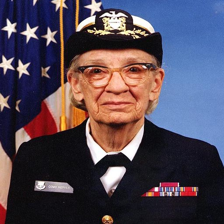

In [7]:
grace_hopper = tf.keras.utils.get_file('image.jpg','https://storage.googleapis.com/download.tensorflow.org/example_images/grace_hopper.jpg')
grace_hopper = Image.open(grace_hopper).resize(IMAGE_SHAPE)
grace_hopper

In [8]:
grace_hopper = np.array(grace_hopper)/255.0
grace_hopper.shape

(224, 224, 3)

In [10]:
result = mobilenet_v2.predict(grace_hopper[np.newaxis, ...].tolist())
result.shape

(1, 1001)

In [11]:
predicted_class = np.argmax(result[0], axis=-1)
predicted_class

653

In [12]:
labels_path = tf.keras.utils.get_file('ImageNetLabels.txt','https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
imagenet_labels = np.array(open(labels_path).read().splitlines())

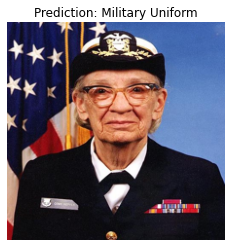

In [13]:
plt.imshow(grace_hopper)
plt.axis('off')
predicted_class_name = imagenet_labels[predicted_class]
_ = plt.title("Prediction: " + predicted_class_name.title())

In [14]:
bucket_name = "kserve"
model_name = "mobilenet_v2"
model_path=f"s3://{bucket_name}/models/{model_name}/0001"

In [15]:
import os
os.environ.update({
    'S3_ENDPOINT'          : 'minio-service.kubeflow:9000',
    'AWS_ACCESS_KEY_ID'    : 'minio',
    'AWS_SECRET_ACCESS_KEY': 'minio123',
    'S3_USE_HTTPS'         : '0',   # Whether or not to use HTTPS. Disable with 0.                        
    'S3_VERIFY_SSL'        : '0'    # If HTTPS is used, controls if SSL should be enabled. Disable with 0.
})  

In [17]:
mobilenet_v2.save(model_path)

[W 221013 07:55:56 saving_utils:318] Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.
[I 221013 07:55:58 builder_impl:774] Assets written to: s3://kserve/models/mobilenet_v2/0001/assets


```
apiVersion: "serving.kserve.io/v1beta1"
kind: "InferenceService"
metadata:
  annotations:
    sidecar.istio.io/inject: "false"
  name: "mobilenet-v2"
spec:
  predictor:
    serviceAccountName: 'sa'
    tensorflow:
      image: "tensorflow/serving:2.5.1"
      storageUri: "s3://kserve/models/mobilenet_v2"
```

In [18]:
KServe = KServeClient()
namespace = utils.get_default_target_namespace()
service_name = "mobilenet-v2"
KServe.get(service_name, namespace=namespace, watch=True, timeout_seconds=120)
isvc_resp=KServe.get(service_name, namespace=namespace)

NAME                 READY                           PREV                    LATEST URL                                                              
mobilenet-v2         Unknown                            0                       100                                                                  
mobilenet-v2         False                              0                       100                                                                  
mobilenet-v2         False                              0                       100                                                                  
mobilenet-v2         False                              0                       100                                                                  
mobilenet-v2         Unknown                            0                       100                                                                  
mobilenet-v2         False                              0                       100                 

In [19]:
isvc_resp

{'apiVersion': 'serving.kserve.io/v1beta1',
 'kind': 'InferenceService',
 'metadata': {'annotations': {'sidecar.istio.io/inject': 'false'},
  'creationTimestamp': '2022-10-13T07:56:23Z',
  'finalizers': ['inferenceservice.finalizers'],
  'generation': 1,
  'managedFields': [{'apiVersion': 'serving.kserve.io/v1beta1',
    'fieldsType': 'FieldsV1',
    'fieldsV1': {'f:metadata': {'f:annotations': {'.': {},
       'f:sidecar.istio.io/inject': {}}},
     'f:spec': {'.': {},
      'f:predictor': {'.': {},
       'f:serviceAccountName': {},
       'f:tensorflow': {'.': {}, 'f:image': {}, 'f:storageUri': {}}}}},
    'manager': 'Swagger-Codegen',
    'operation': 'Update',
    'time': '2022-10-13T07:56:20Z'},
   {'apiVersion': 'serving.kserve.io/v1beta1',
    'fieldsType': 'FieldsV1',
    'fieldsV1': {'f:metadata': {'f:finalizers': {'.': {},
       'v:"inferenceservice.finalizers"': {}}},
     'f:status': {'.': {},
      'f:address': {'.': {}, 'f:url': {}},
      'f:components': {'.': {},
    

In [20]:
import requests
isvc_url = isvc_resp['status']['address']['url']
print(isvc_url)

http://mobilenet-v2.kubeflow-user-example-com.svc.cluster.local/v1/models/mobilenet-v2:predict


In [22]:
X_data = grace_hopper[np.newaxis, ...].tolist()
data = {
    "instances": X_data
}

In [23]:
response = requests.post(isvc_url, json=data)
print(response.text)

{
    "predictions": [[0.199675947, 1.0678966, -0.096099332, 1.10753763, -0.154607415, -0.631894469, -0.0360174924, -2.01866984, -0.14397347, -0.143937051, -0.296572417, 0.527685523, 0.583141685, -0.810139537, -0.65175426, 0.926327348, 0.00984019, -1.29104185, 1.16821468, 0.153163046, -0.587534726, 0.0997167304, 0.238366321, 1.06880593, -0.694764137, -0.4509179, 0.151563928, -1.01612639, 0.564389467, 0.173862651, -1.75571036, -0.286650717, 0.393435389, 0.523286462, -0.768849373, -1.38230455, -1.22526884, -1.91696084, -0.829766273, -0.323191166, 0.0605888963, -0.756531417, 0.404557735, -0.411388397, -1.16386867, -0.185540974, 0.599889517, -1.12346721, -0.142629325, -1.48209381, 0.737982571, 0.118609346, -0.433812171, -1.16172123, 0.463743031, -0.898387134, -0.136469662, 0.106437027, 0.00677442551, 0.260293156, -0.082685709, -0.171738356, -0.745466709, 0.0606884286, -0.662643969, 0.371543288, 0.606449, -0.11554873, -0.456262529, -0.561569691, 0.322999179, -0.192452818, -0.270121366, -0.0

In [24]:
pred = response.json()['predictions'][0]

In [25]:
predicted_class = np.argmax(pred, axis=-1)
print(predicted_class)
imagenet_labels[predicted_class]

653


'military uniform'